# Classification - Step 1

In [16]:
import numpy as np 
import pandas as pd
import scipy.stats as sp
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tqdm.notebook import tqdm

from joblib import Parallel, delayed

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [17]:
def my_classification(X_train, X_test, y_train, y_test, class_number = 2, features = 0, alpha = 0, n_features=1,n_split = 5, n_trials = 100, n_score = 1, param_search=True):
    
    warnings.filterwarnings('ignore')
    
    test_scores = np.zeros((n_trials, n_scores))
    train_scores = np.zeros((n_trials, n_scores))
    best_param, best_f = list(), list()
    
    for i_N in range(n_trials):
   
        # STEP 1 - Search/Set best hyperparameters 
        if param_search == True: 
            pipe, param_grid = set_pipeline(alpha, param_search, n_features)
            grid_search = GridSearchCV(estimator = pipe, param_grid=param_grid, 
                                       scoring='f1', cv=n_split, n_jobs=10, verbose=0)
            grid_search.fit(X_train,y_train) 
            
            # Extract best features and best parameters   
            
            alpha_best = grid_search.best_params_['lasso__alpha']
            best_param.append(alpha_best)
            best_features = extract_features(grid_search.best_estimator_.named_steps["lasso"].coef_, features)
            best_f.append(best_features)     
            
            pipe, _ = set_pipeline(alpha = alpha_best, param_search=False)
            
        else:
            pipe, _ = set_pipeline(alpha = alpha, param_search = param_search)
            
        # STEP 2 - Learn model with best params
        pipe.fit(X_train, y_train)
        
        y_train_pred = pipe.predict(X_train)
        y_train_pred = np.int64(np.round(y_train_pred)) 
        
        train_scores[i_N,...] = compute_scores(y_train, y_train_pred)
    
        # STEP 3 - Estimate the model for the test set
        y_pred = pipe.predict(X_test)
        y_pred = np.int64(np.round(y_pred)) 

        # STEP 4 - Compute performance metrics
        test_scores[i_N,...] = compute_scores(y_test, y_pred)
    
    return test_scores, train_scores, best_param, best_f

def set_pipeline(alpha=0, param_search=True, n_features=1):
    
    if param_search == True:
        pipe= Pipeline(steps=[('scaler', StandardScaler()),
                              ('lasso', Lasso())])
        param_grid = {'lasso__alpha':alpha}
    else:
        pipe= Pipeline(steps=[('scaler', StandardScaler()),
                              ('lasso', Lasso(alpha=alpha))])
        param_grid = 0

    return pipe, param_grid

def compute_scores(y_test, y_pred):    
    # Compute Accuracy, Precision, F1-score and Recall
    
    acc_score = accuracy_score(y_test, y_pred)
    pr_score, r_score, f1, _= precision_recall_fscore_support(y_test, y_pred, average='weighted')
    scores = np.array([acc_score, pr_score, r_score, f1])
    
    return scores

def extract_data_and_features(filename):
    
    def select_dataset(filename):
        df = pd.read_csv(filename)
        df = df.set_index('ID')
        col = df.columns
        if 'MMSE' in col:
            df['MMSE'] = df['MMSE'].replace(np.nan, 30)
        if 'UPDRS' in col:
            df['UPDRS'] = df['UPDRS'].replace(np.nan, 0)
        return df

    factors_df = select_dataset(filename)
    features = list()
    for column in factors_df.columns:
        if (column != 'Groups'):
            features.append(column)
            
    X = factors_df[features]
    y = factors_df['Groups']
    labels = factors_df['Groups'].unique()
    X = X.to_numpy()
    y = y.to_numpy()

    return X,y,features

def extract_features(coef, features_name):       
    idx_features =  np.where(coef != 0)
    idx_features = idx_features[0]
    best_f = list()
    for idx in range(len(idx_features)):
        best_f.append(features_name[idx_features[idx]])
        
    return best_f

def counter_features(features):
    count_features = Counter(x for sublist in features for x in sublist)
    y = [count for tag, count in count_features.most_common()]
    x = [tag for tag, count in count_features.most_common()]

    return x,y

In [18]:
# Set variable 

path_in = #input_path_folder

class_number = 2
n_splits = 5
n_trials=100

# Set hyperparameters
alpha = np.logspace(-3,0,4)

n_rs = [0,1,2]

score_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
n_scores = len(score_names)

groups = ['onlyPSD', 'onlyWPLI', 'onlyOCC', 'onlyPSDWPLI', 'onlyPSDOCC', 'onlyWPLIOCC', 'onlyEEG']
#name of input dataframe

n_groups = len(groups)


In [19]:
# Matrix and List inizialization
train_score = np.zeros((len(n_rs),len(groups),n_splits,n_trials,n_scores))
test_score = np.zeros((len(n_rs),len(groups),n_splits,n_trials,n_scores))
param = list() 
best_f = list()

In [20]:
for i_rs in tqdm(n_rs): 
    
    loo = StratifiedKFold(n_splits=n_splits, random_state=i_rs, shuffle=True)
    
    for i_group, group in enumerate(tqdm(groups)):
        
        filename = path_in + group + '_' + str(class_number) + 'class.csv'
        
        # Set data matrix X and label vector y
        X, y, features = extract_data_and_features(filename)
        
        num_features_group = np.linspace(1,X.shape[1],X.shape[1], dtype=int)
        
        #Classification
        score_lst = Parallel(n_jobs=10, verbose=0)(
                    delayed(my_classification)(X[i_train], X[i_test], y[i_train], y[i_test], class_number, features, alpha, num_features_group, n_splits, n_trials, n_scores, param_search=True) for i_train, i_test in loo.split(X,y))
        
        # Matrix and List inizialization
        test_scores = np.zeros((n_splits, n_trials, n_scores))
        train_scores = np.zeros((n_splits, n_trials, n_scores))
        best_param = list()
        best_features= list()
        
        for i_fold in range(n_splits): 
            test_scores[i_fold,...] = score_lst[i_fold][0]
            train_scores[i_fold,...] = score_lst[i_fold][1]
            best_param.append(score_lst[i_fold][2]) 
            best_features.append(counter_features(score_lst[i_fold][3]))  
        
        best_f.append(best_features)    
        param.append(best_param) # n_random_state x n_groups x n_fold x n_trials x n_param
        train_score[i_rs,i_group,...] = train_scores # n_random_state x n_groups x n_fold x n_trials x n_scores
        test_score[i_rs,i_group,...] = test_scores # n_random_state x n_groups x n_fold x n_trials x n_scores
        

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
plt1 = test_score.mean(axis=3) # mean trials
plt1_mean = plt1.mean(axis=(0,2)) # mean random-state and folds
plt1_std = np.std(np.mean(plt1,axis=2),axis=0) # standard deviation of scores

group_names = ['PSD', 'wPLI', 'oCC', 'PSD + wPLI', 'PSD + oCC', 'wPLI + oCC', 'All'] 

In [25]:
def matrix_plot(data, data_std, label, color):
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Set matrix to plot
    data_mat = np.array([np.concatenate(([data[0]], [data[4]], [data[3]])), np.concatenate(([data[1]], [data[5]], [0])), 
                         np.concatenate(([data[2]], [0], [0])), np.concatenate(([data[6]], [0], [0]))])
    
    data_mat_std = np.array([np.concatenate(([data_std[0]], [data_std[4]], [data_std[3]])), np.concatenate(([data_std[1]], [data_std[5]], [0])), 
                         np.concatenate(([data_std[2]], [0], [0])), np.concatenate(([data_std[6]], [0], [0]))])


    data_mat = np.multiply(data_mat,100)
    data_mat_std = np.multiply(data_mat_std,100)
    text_xpos = [0, 1, 2]
    text_ypos = [0, 1, 2, 3]
    
    # Plot scores 
    a = plt.imshow(data_mat, alpha = 1)
    plt.set_cmap(color)
    cbar = plt.colorbar(a, shrink=1)
    plt.clim([30,100])
    cbar.ax.set_ylabel(ylabel=label, fontsize=16)
    ticklabel= np.linspace(30,100,8, dtype='int')
    cbar.ax.set_yticklabels(ticklabel, fontsize=14)
    
    #Plot mean and standard deviation values as text
    for i in range(4):
        for j in range(3):
            if int(np.round(data_mat[i][j],1)) != 0:
                plt.text(text_xpos[j], text_ypos[i], str(int(np.round(data_mat[i][j]))) + u"\u00B1" + str(int(np.round(data_mat_std[i][j]))), 
                        fontsize=16, horizontalalignment = 'center', color='black')
        
    plt.xticks([0,1,2])
    ax.set_xticklabels(['', 'oCC', 'wPLI'], fontsize=16);
    plt.yticks([0,1,2,3])
    ax.set_yticklabels(['PSD', 'wPLI', 'oCC', 'All'], fontsize=16);

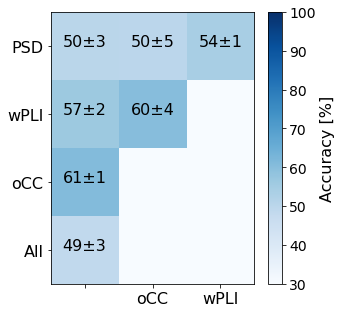

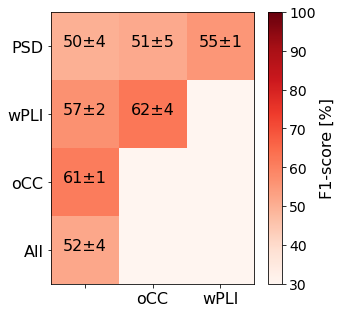

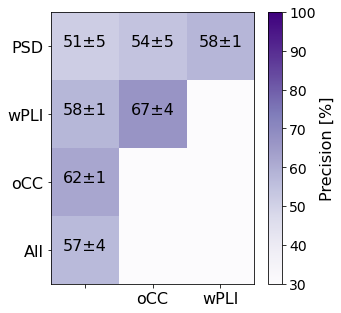

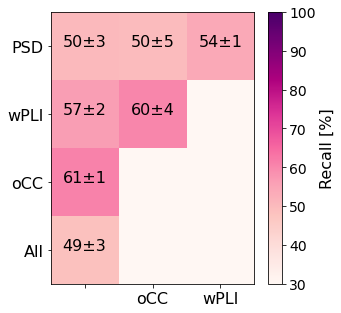

In [26]:
acc = plt1_mean[...,0] # Accuracy
acc_std = plt1_std[...,0]
label = 'Accuracy [%]'
matrix_plot(acc, acc_std, label, 'Blues')

f1 = plt1_mean[...,3] # F1-score
f1_std = plt1_std[...,3]
label = 'F1-score [%]'
matrix_plot(f1, f1_std, label, 'Reds')

precision = plt1_mean[...,1] # Precision
precision_std = plt1_std[...,1]
label = 'Precision [%]'
matrix_plot(precision, precision_std, label, 'Purples')

recall = plt1_mean[...,2] # Recall
recall_std = plt1_std[...,2]
label = 'Recall [%]'
matrix_plot(recall, recall_std, label,'RdPu')

In [35]:
def plot_violin(acc, f1, alpha, n_rs = 0, n_groups = 0, color_line = 'black', color = 'black', label = '', pos=0, tick_pos = 0):
    
    # Create patch for legend
    patch_f1 = list()
    for i_rs in range(len(n_rs)): 
        patch_f1.append(mpatches.Patch(color=color[i_rs], alpha=alpha[i_rs]))
        
    # Create violin subplots
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=False)
    for i_rs in range(len(n_rs)): 
          
        
        violin_parts = ax.violinplot(np.multiply(f1[i_rs,...].T,100), positions=pos+.3*i_rs, vert=True, 
                       widths=.3,showmeans=True, showextrema=False, showmedians=False)
        
        for i_fold in range(5):
            ax.scatter((pos+.3*i_rs), np.multiply(f1[i_rs,:,i_fold],100), color=color_line[i_rs], s=1)
            
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(group_names, rotation = 30, fontsize=14, ha='right')
        for pc in violin_parts['bodies']:
            pc.set_facecolor(color[i_rs])
            pc.set_edgecolor(color_line[i_rs])
            pc.set_alpha(alpha=.25)

        vp = violin_parts['cmeans']
        vp.set_edgecolor(color_line[i_rs])                    
        vp.set_linewidth(2)
    
    ax.set_ylabel('F1-score [%]', fontsize=16)  
    ax.legend(patch_f1, label, loc='upper left')   
    ax.set_ylim([30, 100])
    ticklabel = np.linspace(30,100,8, dtype='int')
    ax.set_yticklabels(ticklabel, fontsize=14)

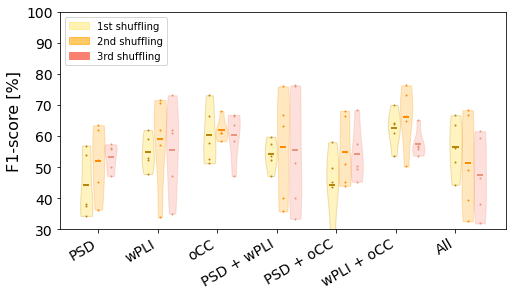

In [36]:
acc = np.mean(test_score[...,0],axis=3) # Accuracy [n_random_state x n_groups x n_fold]
f1 = np.mean(test_score[...,3],axis=3) # F1-score [n_random_state x n_groups x n_fold]

n_groups = len(groups)

colors = ['gold', 'orange', 'salmon']
color_line = ['darkgoldenrod', 'darkorange', 'darksalmon']
alpha = [.3, .6, 1]
labels = ['1st shuffling', '2nd shuffling', '3rd shuffling']
position = np.linspace(.7,(n_groups*1.5)-.7,n_groups)
tick_position = np.linspace(1,(n_groups*1.5)-.7,n_groups)
                       
plot_violin(acc, f1, alpha, n_rs = n_rs, n_groups = n_groups, 
            color = colors, color_line = color_line, label = labels, 
            pos = position, tick_pos = tick_position)